In [1]:
import matplotlib.pyplot as plt
import numpy as np
import phate
import random
import scipy as sp
import scprep
import sys

from sklearn.neighbors import NearestNeighbors


In [2]:
tree, branches = phate.tree.gen_dla(
    n_dim = 100, n_branch = 4, branch_length = 300, rand_multiplier = 2, seed=37, sigma = 5
)
print(tree.shape, branches.shape)

(1200, 100) (1200,)


In [3]:
data = tree
data.shape

(1200, 100)

In [4]:
phate_op = phate.PHATE()
data_ph = phate_op.fit_transform(tree)

Calculating PHATE...
  Running PHATE on 1200 observations and 100 variables.
  Calculating graph and diffusion operator...
    Calculating KNN search...
    Calculated KNN search in 0.16 seconds.
    Calculating affinities...
    Calculated affinities in 0.01 seconds.
  Calculated graph and diffusion operator in 0.18 seconds.
  Calculating optimal t...
    Automatically selected t = 11
  Calculated optimal t in 1.10 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.25 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 1.57 seconds.
Calculated PHATE in 3.12 seconds.


/Users/sumner/miniforge3/envs/spot-mark-gene/lib/python3.10/site-packages/scprep/plot/utils.py:104: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


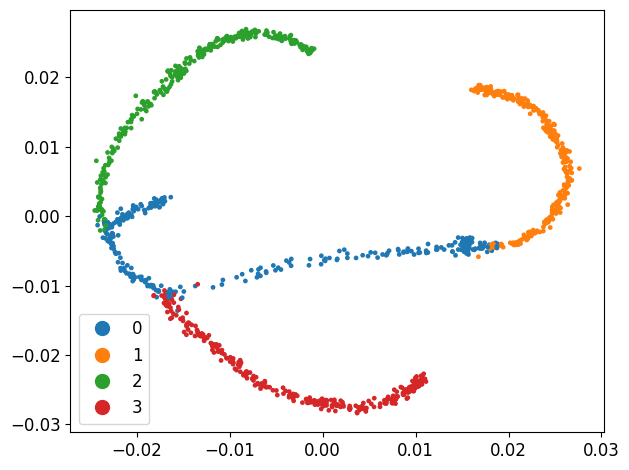

In [5]:
ax = scprep.plot.scatter2d(data_ph, c=branches)

In [6]:
################
# DISTINCTNESS #
################
# Find and sort eigenvectors and eigenvalues of diffusion operators. 
phate_op_eigvals, phate_op_eigvecs = np.linalg.eig(phate_op.diff_op)
idx = np.abs(phate_op_eigvals).argsort()[::-1]
phate_op_eigvals = phate_op_eigvals[idx]
phate_op_eigvecs = phate_op_eigvecs[:, idx]
phate_op_eigvals = np.power(phate_op_eigvals, phate_op.optimal_t)
phate_op_eigvecs = phate_op_eigvecs.dot(np.diag(phate_op_eigvals))

# Number of eigenvectors (~ dimensions) to consider.
phate_op_eigvals_diff = phate_op_eigvals - np.roll(phate_op_eigvals, 1)
n_eigvecs = 1

In [7]:
# Increase the number of eigenvectors until 
while (phate_op_eigvals_diff[n_eigvecs + 1] > 2 * phate_op_eigvals_diff[n_eigvecs]):
  n_eigvecs += 1
  
n_eigvecs

2

In [10]:
# curr = phate_op_eigvecs[:, 1:n_eigvecs+1]
curr = phate_op_eigvecs[:, 1:].copy()
lower_half_abs = np.percentile(np.abs(curr), 50)
curr[np.abs(curr) < lower_half_abs] = 0

maxes = curr.argmax(axis=0)
mines = curr.argmin(axis=0)
vals = np.unique(np.hstack((maxes, mines)))
distinct = vals

In [11]:
# Find the extremas (min and max) of the considered eigenvectors.
# Keep them in the order of the eigenvalues by weaving min and max values.
# min_eigs = phate_op_eigvecs[:,1:n_eigvecs+1].argmin(0)
# max_eigs = phate_op_eigvecs[:,1:n_eigvecs+1].argmax(0)
# combined_eigs = np.empty((min_eigs.size + max_eigs.size,), dtype=min_eigs.dtype)
# combined_eigs[0::2] = min_eigs
# combined_eigs[1::2] = max_eigs

# Remove duplicates.

# for e in combined_eigs:
#     if e not in most_distinct_points:
#         most_distinct_points.append(e)

most_distinct_points = []

# Always skip the first trivial eigenvector
for i in np.arange(n_eigvecs):
  cur_eigvec = np.copy(phate_op_eigvecs[:,i+1])
  # Sometimes the eigvectors are skewed towards one side (much more possitive values than negative values and vice versa). This part ensures only the extrema on the more significant side is taken.
  lower_half_abs = np.percentile(np.abs(cur_eigvec), 90)
  cur_eigvec[np.abs(cur_eigvec) < lower_half_abs] = 0
  max_eig = np.argmax(cur_eigvec)
  min_eig = np.argmin(cur_eigvec)
  if cur_eigvec[max_eig] > 0 and max_eig not in most_distinct_points:
    most_distinct_points.append(max_eig)
  if cur_eigvec[min_eig] < 0 and min_eig not in most_distinct_points:
    most_distinct_points.append(min_eig)

most_distinct_points = np.array(most_distinct_points)

In [12]:
most_distinct_points#, distinct

array([ 599, 1197])

In [13]:
# These extremas could contain branch points but 
# We will classify them based on their intrinsic dimensionality.

#######################
# INTRINSIC DIMENSION #
#######################

# Based on maxLikPointwiseDimEst() of this R package.
# https://cran.r-project.org/web/packages/intrinsicDimension/README.html

# Up to 100 dimensions of diffusion maps, 
# raised to the same power as tdetermined by PHATE.
dm_dims = min(data.shape[1], 100)
diff_map = phate_op_eigvecs[:,:dm_dims]
# diff_map = diff_map.dot(np.diag(np.power(phate_op_eigvals[:dm_dims], 11)))

In [14]:
diff_map.shape

(1200, 100)

In [15]:
phate_op.graph.inverse_transform(diff_map).shape

(1200, 100)

In [16]:
phate_op.graph.interpolate(diff_map).shape

ValueError: Either `transitions` or `Y` must be provided.

In [17]:
(phate_op.graph.transitions @ diff_map).shape

AttributeError: 'kNNGraph' object has no attribute 'transitions'

In [18]:
# Any transformation on the landmark kernel is trivially extended to the 
# data space by multiplying by the transition matrix.

np.all((phate_op.graph.transitions @ diff_map) == phate_op.graph.interpolate(diff_map))

AttributeError: 'kNNGraph' object has no attribute 'transitions'

In [19]:
# diff_map = phate_op.graph.inverse_transform(diff_map)

In [20]:
# diff_map = (phate_op.graph.transitions @ diff_map)

In [21]:
diff_map = phate_op.graph.interpolate(diff_map)
diff_map.shape

ValueError: Either `transitions` or `Y` must be provided.

In [22]:
diff_map = (pnm @ diff_map)

NameError: name 'pnm' is not defined

In [24]:
# diff_map = phate_op.graph.interpolate(diff_map)


# Rank all neighbors in diffusion map coordinates.
nbrs = NearestNeighbors(
  # n_neighbors=dm_dims,
  n_neighbors=diff_map.shape[0],
  algorithm='ball_tree'
  ).fit(diff_map)
nn_distances, nn_indices = nbrs.kneighbors(diff_map)
nn_distances = nn_distances[:,1:]
nn_indices = nn_indices[:,1:]

In [25]:
diff_map.shape[0]

1200

In [26]:
# NOTE: using KNN on diff_map is not invertable
phate_op.graph.interpolate(nn_indices).max()

ValueError: Either `transitions` or `Y` must be provided.

In [27]:
# Maximum Likelihood pointwise dimensionality estimation
# Hill (1975), Levina and Bickel (2005)
row_max = np.max(nn_distances, axis=1)
row_max = row_max.reshape(len(row_max), 1)
dim_est = np.sum(np.log(row_max / nn_distances), axis=1)

# Calculate the average dim_est of local neighborhood.
n_nbrs = min(data.shape[0] // 20, 100)
nbrs_dim_est = np.average(dim_est[nn_indices[:,:n_nbrs]], axis=1)

# nbrs_dim_est = phate_op.graph.interpolate(nbrs_dim_est)






# Calculate ranking of neighborhood dim_est, from low to high
temp = nbrs_dim_est.argsort()
nbrs_dim_est_ranks = np.empty_like(temp)
nbrs_dim_est_ranks[temp] = np.arange(len(nbrs_dim_est))

# Make sure that all distinct points are end points (low dim_est), not branch point (high dim_est)
low_dim_est_mask = nbrs_dim_est_ranks[most_distinct_points] < data.shape[0] // 2
most_distinct_points = most_distinct_points[low_dim_est_mask]

In [28]:
# phate_op.graph.data_pca.inverse_transform(diff_op_t)

In [29]:
(phate_op.graph.interpolate(phate_op.diff_op) @ phate_op.graph._landmarks_to_data()).shape

ValueError: Either `transitions` or `Y` must be provided.

In [30]:
pnm = phate_op.graph._landmarks_to_data()

AttributeError: 'kNNGraph' object has no attribute '_landmarks_to_data'

In [31]:
pmn = phate_op.graph._data_transitions()
pmn.shape

AttributeError: 'kNNGraph' object has no attribute '_data_transitions'

In [32]:
pnm = phate_op.graph._transitions
pnm.shape

AttributeError: 'kNNGraph' object has no attribute '_transitions'

In [33]:
(pnm @ phate_op.diff_op @ pmn).shape

NameError: name 'pnm' is not defined

In [35]:
##################################
# DIFFUSING DIRAC FOR END POINTS #
##################################

branch_points = []
classes = np.zeros(data.shape[0], dtype="int32")
classes_value = np.repeat(-float('inf'), data.shape[0])
for end_point_index in np.arange(most_distinct_points.size):
  cur_end_point = most_distinct_points[end_point_index]
  
  # undo_diff = (phate_op.graph.interpolate(phate_op.diff_op) @ phate_op.graph._landmarks_to_data())
  # undo_diff = (pnm @ phate_op.diff_op @ pmn)
  # diff_op_t = np.linalg.matrix_power(
  #   undo_diff, 
  #   phate_op.optimal_t
  # )
  diff_op_t = np.linalg.matrix_power(phate_op.diff_op, phate_op.optimal_t)
  # break

  # diff_op_t = phate_op.graph.interpolate(diff_op_t)
  # diff_op_t = (phate_op.graph.transitions @ diff_op_t)


  branch_point_dim_est_avg_cache = -float('inf')
  for it in range(20):
    branch_from_end_point = diff_op_t[:,cur_end_point]
    branch_max = np.max(branch_from_end_point)
    branch_min = np.min(branch_from_end_point)
    branch_threshold = branch_min + (branch_max - branch_min) * 0.1
    deviation_from_branch_threshold = \
      branch_from_end_point - branch_threshold
    deviation_from_branch_threshold[deviation_from_branch_threshold < 0] = \
      float('inf')
    cur_branch_point = deviation_from_branch_threshold.argmin()
    potential_branch_points = \
      np.argpartition(deviation_from_branch_threshold, 20)[:20]
    branch_point_dim_est_avg = \
      np.average(nbrs_dim_est[potential_branch_points])
    if (branch_point_dim_est_avg < branch_point_dim_est_avg_cache):
      break
    branch_point_dim_est_avg_cache = branch_point_dim_est_avg
    
    diff_op_t = diff_op_t.dot(phate_op.diff_op)
    # # undo_diff = (phate_op.graph.interpolate(phate_op.diff_op) @ phate_op.graph._landmarks_to_data())
    # undo_diff = (pnm @ phate_op.diff_op @ pmn)
    # diff_op_t = diff_op_t.dot(
    #     undo_diff    
    #   )


  branch_points.append(cur_branch_point)
  on_branch_mask = diff_op_t[:,cur_end_point] > branch_threshold
  color = diff_op_t[:,cur_end_point]
  on_branch_mask[color < classes_value] = 0
  color[np.logical_not(on_branch_mask)] = -np.max(color)
  classes_value[on_branch_mask] = color[on_branch_mask]
  classes[on_branch_mask] = end_point_index + 1
  # ax = scprep.plot.scatter2d(data_ph, c=color)
  # plot_numbers = np.repeat("", data_ph.shape[0])
  # plot_numbers[cur_end_point] = 'e'
  # plot_numbers[cur_branch_point] = 'b'
  # bbox_props = dict(boxstyle="circle,pad=0.3", fc="w", ec="r", lw=2)
  # sys.stdout = open('trash', 'w')
  # for i, txt in enumerate(plot_numbers):
  #   ax.annotate(txt, (data_ph[i][0], data_ph[i][1]), size=15, bbox=bbox_props)
  # sys.stdout = sys.__stdout__

In [36]:
#####################
# REMOVE DUPLICATES #
#####################
# We want to remove branch points that are too close together.

branch_points = np.array(branch_points)
branch_point_nbrs = nn_indices[branch_points,:n_nbrs]
branch_point_pairs_mask = np.isin(branch_point_nbrs, branch_points)
center_branch_point = branch_points[np.where(branch_point_pairs_mask)[0]]
neighbor_branch_point = branch_point_nbrs[branch_point_pairs_mask]
branch_point_pairs = list(zip(center_branch_point, neighbor_branch_point))

In [37]:
# For each pair of branch_points, keep only the one with higher eigenvalue.
# (mdb_pairs, by construction, is sorted by decreasing eigenvalue corresponding 
# to the first point of each pair.)
points_to_exclude = []
for pair in branch_point_pairs:
  if pair[0] not in points_to_exclude:
    points_to_exclude.append(pair[1])

branch_points = np.delete(branch_points,
  np.argwhere(np.isin(branch_points, points_to_exclude)))

In [38]:
branch_points

array([ 458, 1080])

/Users/sumner/miniforge3/envs/spot-mark-gene/lib/python3.10/site-packages/scprep/plot/utils.py:104: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


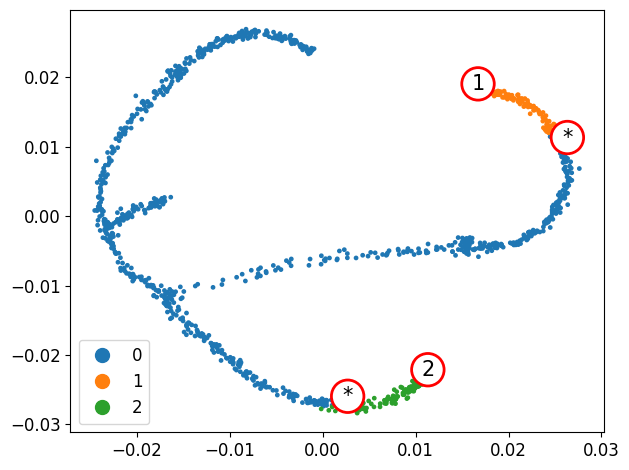

In [39]:
# Plot by class with end points and branch points
ax = scprep.plot.scatter2d(data_ph, c=classes)
plot_numbers = np.repeat("", data_ph.shape[0])
plot_numbers[most_distinct_points] = \
  np.arange(most_distinct_points.shape[0]) + 1
plot_numbers[branch_points] = "*"
bbox_props = dict(boxstyle="circle,pad=0.3", fc="w", ec="r", lw=2)

# sys.stdout = open('trash', 'w')
for i, txt in enumerate(plot_numbers):
  ax.annotate(txt, (data_ph[i][0], data_ph[i][1]), size=15, bbox=bbox_props)


In [44]:
# colors = phate_op.graph.interpolate(phate_op_eigvecs[:,eigvec_index])
colors = phate_op_eigvecs[:,eigvec_index]

In [45]:
colors.min(), colors.max()

(-0.050653643774546606, 0.044522227998032356)

In [46]:
pairwise_dist = sp.spatial.distance.cdist(colors.reshape(-1, 1), colors.reshape(-1, 1))

In [47]:
import seaborn as sns

In [48]:
pairwise_dist.min(), pairwise_dist.max()


(0.0, 0.09517587177257897)

<Axes: >

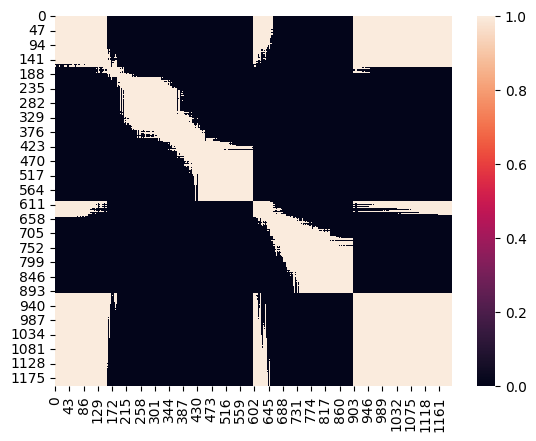

In [49]:
sns.heatmap((pairwise_dist < 0.01).astype(int))

<Axes: >

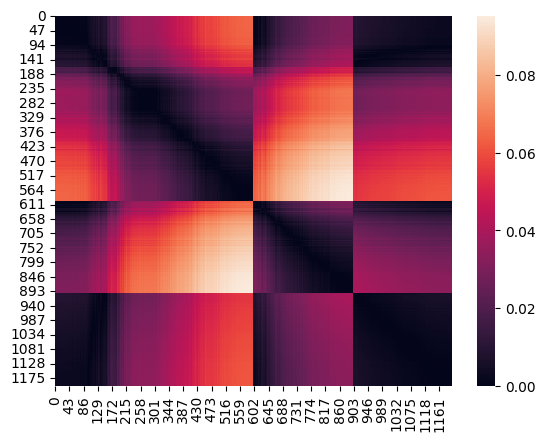

In [50]:
sns.heatmap(pairwise_dist)

In [113]:
n = 300
k = 10
top_n = pairwise_dist.argsort(axis=1)[:, ::-1][:, :n]
top_f = top_n[:, ::-1][:, -k:] # <- furthest k of the nearest n
top_dn = pairwise_dist.take(top_n)
top_df = pairwise_dist.take(top_f)

<Axes: >

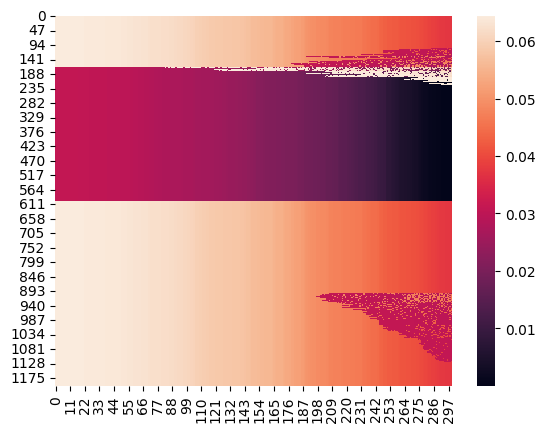

In [114]:
sns.heatmap(top_dn)

<Axes: >

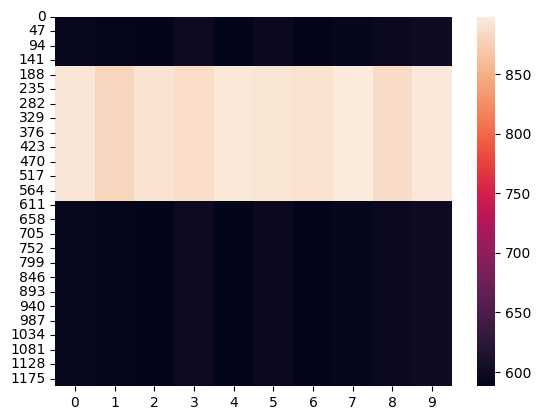

In [120]:
sns.heatmap(top_f)

In [136]:
np.where(np.ediff1d(top_f[:, 0]) != 0)[0]

(array([160, 161, 164, 599]),)

In [131]:
found = []
magic_num = None
last = None

for idx, row in enumerate(top_f):
    
    first = row[0]
    if idx == 0:
        last = row[0]
        magic_num = row[0]
        continue
    
    if last == magic_num and first == last:
        continue
    
    if last == magic_num and first != last:
        found.append(idx - 1)

    last = first

In [137]:
found = np.where(np.ediff1d(top_f[:, 0]) != 0)[0]

/Users/sumner/miniforge3/envs/spot-mark-gene/lib/python3.10/site-packages/scprep/plot/utils.py:104: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


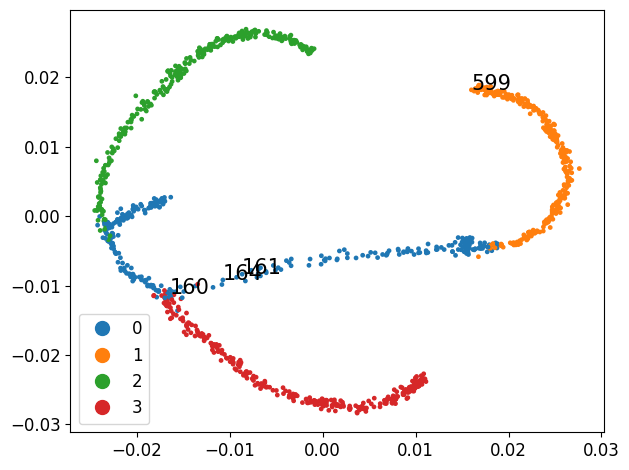

In [138]:
ax = scprep.plot.scatter2d(data_ph, c=branches)
zzz = found
# zzz = np.unique(Y.mean(axis=1).round().astype(int))
for ___I, txt in enumerate(zzz):
  coord = zzz[___I]
  ax.annotate(txt, (data_ph[coord][0], data_ph[coord][1]), size=15)

<Axes: >

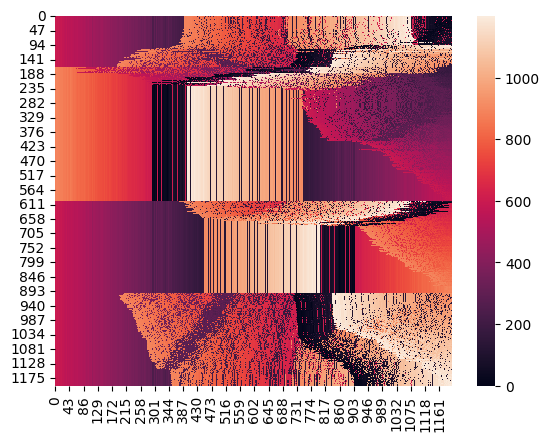

In [87]:
sns.heatmap(top_n)

<Axes: >

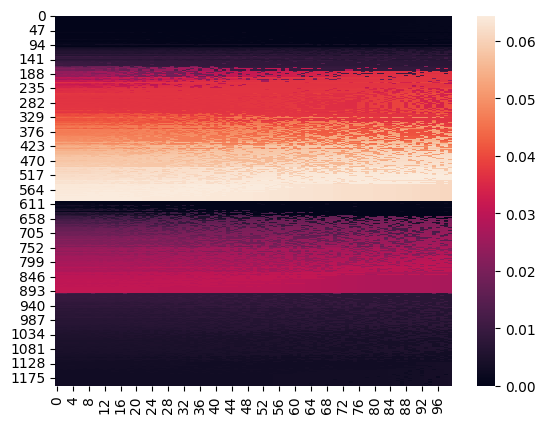

In [93]:
sns.heatmap(top_d[:, ::-1][:, :100])

<Axes: >

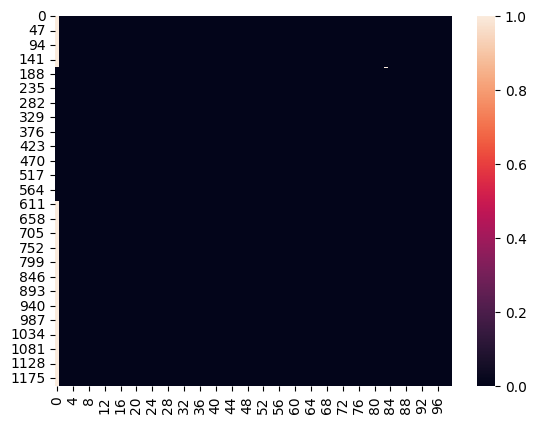

In [75]:
tr, tc = np.where(top_n >np.percentile(top_n, 99))
top_n[:, :] = 0
top_n[tr, tc] = 1
sns.heatmap(top_n)

/Users/sumner/miniforge3/envs/spot-mark-gene/lib/python3.10/site-packages/scprep/plot/utils.py:104: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/Users/sumner/miniforge3/envs/spot-mark-gene/lib/python3.10/site-packages/scprep/plot/utils.py:104: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


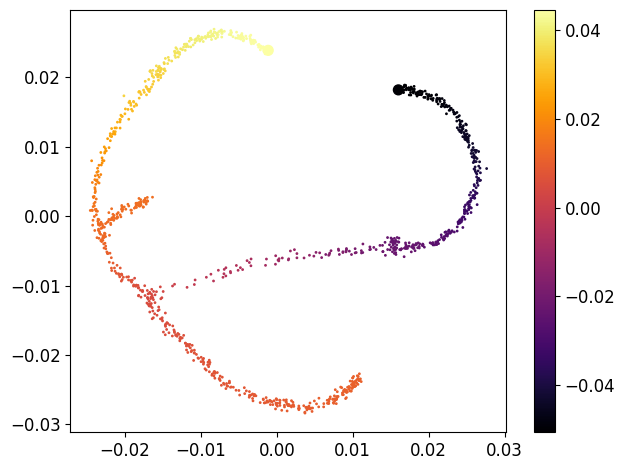

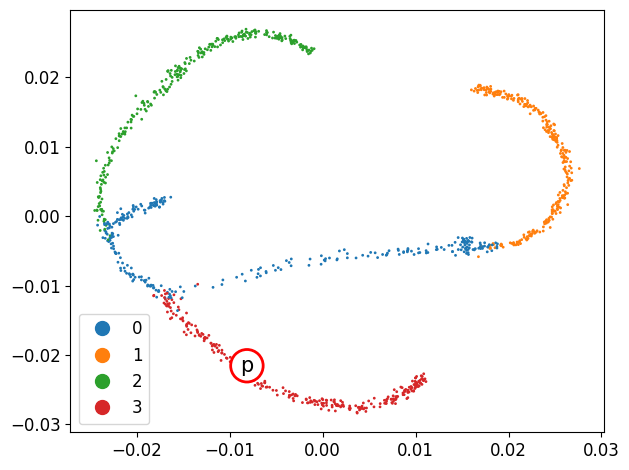

In [42]:
# Plot by an eigenvector
eigvec_index = 1
size = np.ones(data.shape[0])
size[np.argmax(phate_op_eigvecs[:,eigvec_index])] = 50
size[np.argmin(phate_op_eigvecs[:,eigvec_index])] = 50
scprep.plot.scatter2d(data_ph, c=
                      phate_op_eigvecs[:,eigvec_index], 
                      # phate_op.graph.transitions @ phate_op_eigvecs[:,eigvec_index],
                      # phate_op.graph.interpolate(phate_op_eigvecs[:,eigvec_index]), 
                      s=size)

# Plot one point
point_index = 1000
size = np.ones(data.shape[0])
size[point_index]
ax = scprep.plot.scatter2d(data_ph, c=branches, s=size)
plot_numbers = np.repeat("", data_ph.shape[0])
plot_numbers[point_index] = "p"
bbox_props = dict(boxstyle="circle,pad=0.3", fc="w", ec="r", lw=2)

for i, txt in enumerate(plot_numbers):
  ax.annotate(txt, (data_ph[i][0], data_ph[i][1]), size=15, bbox=bbox_props)

/Users/sumner/miniforge3/envs/spot-mark-gene/lib/python3.10/site-packages/scprep/plot/utils.py:104: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


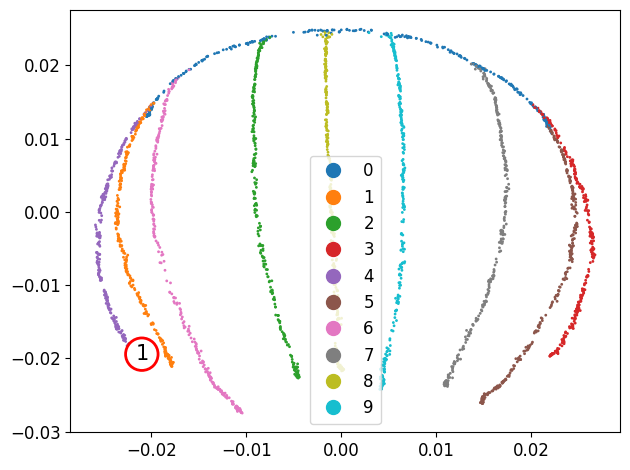

In [228]:
# Based on most distinct indices.
size = np.ones(data.shape[0])
size[most_distinct_points] = 50
ax = scprep.plot.scatter2d(data_ph, c=branches, s=size)
plot_numbers = np.repeat("", data_ph.shape[0])
plot_numbers[most_distinct_points] = \
  np.arange(most_distinct_points.shape[0]) + 1
bbox_props = dict(boxstyle="circle,pad=0.3", fc="w", ec="r", lw=2)

sys.stdout = open('trash', 'w')
for i, txt in enumerate(plot_numbers):
  ax.annotate(txt, (data_ph[i][0], data_ph[i][1]), size=15, bbox=bbox_props)

/Users/sumner/miniforge3/envs/spot-mark-gene/lib/python3.10/site-packages/scprep/plot/utils.py:104: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/Users/sumner/miniforge3/envs/spot-mark-gene/lib/python3.10/site-packages/scprep/plot/utils.py:104: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


<Axes: >

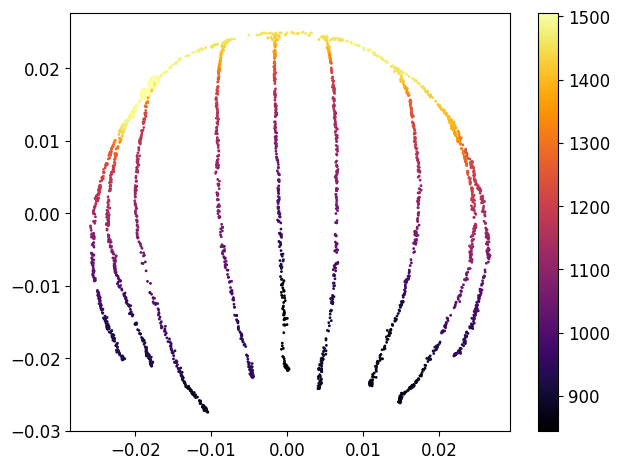

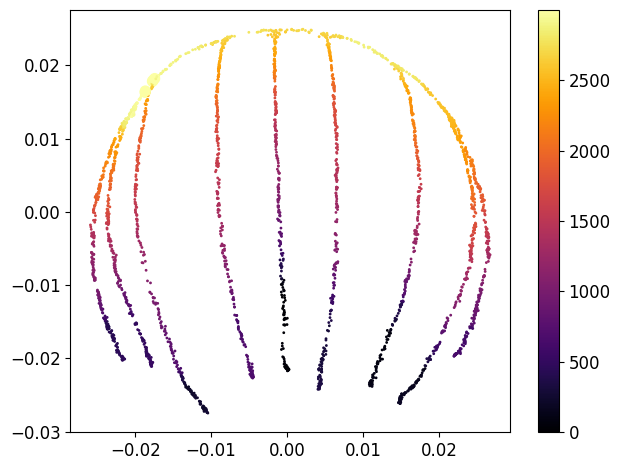

In [229]:
# Based on intrinsic dimensionality.
highest_nbrs_dim_est = nbrs_dim_est.argsort()[-5:]
size = np.ones(data.shape[0])
size[highest_nbrs_dim_est] = 50
scprep.plot.scatter2d(data_ph, c=nbrs_dim_est, s=size)

# Based on ranking of intrinsic dimensionality
scprep.plot.scatter2d(data_ph, c=nbrs_dim_est_ranks, s=size)

/Users/sumner/miniforge3/envs/spot-mark-gene/lib/python3.10/site-packages/scprep/plot/utils.py:104: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/Users/sumner/miniforge3/envs/spot-mark-gene/lib/python3.10/site-packages/scprep/plot/utils.py:104: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


<Axes: >

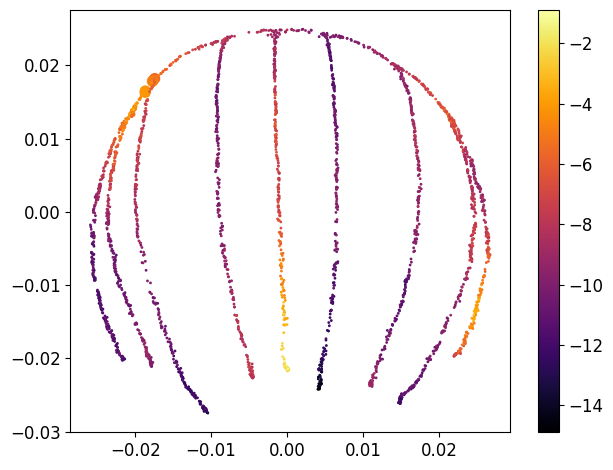

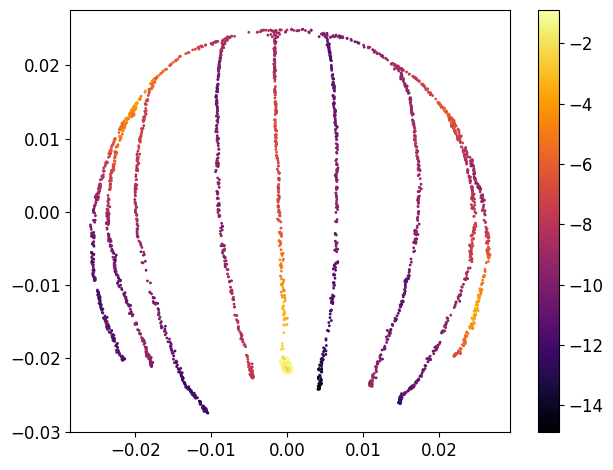

In [98]:
##############
# CENTRALITY #
##############

def _power_iteration(A, num_simulations):
  # Ideally choose a random vector
  # To decrease the chance that our vector
  # Is orthogonal to the eigenvector
  b_k = np.random.rand(A.shape[1])
  b_k = b_k[:, np.newaxis]
  for _ in range(num_simulations):
    # calculate the matrix-by-vector product Ab
    b_k1 = np.dot(A, b_k)
    # calculate the norm
    b_k1_norm = np.linalg.norm(b_k1)
    # re normalize the vector
    b_k = b_k1 / b_k1_norm
  return b_k

kernel = phate_op.graph.kernel
centrality = _power_iteration(kernel.todense(), 100)
scprep.plot.scatter2d(data_ph, c=np.log(centrality), s=size)

most_central_nn_indices = (-centrality).flatten().argsort()[0,:5].tolist()[0]

size = np.ones(data.shape[0])
size[most_central_nn_indices] = 50
scprep.plot.scatter2d(data_ph, c=np.log(centrality), s=size)


In [108]:
mdp_ranking

array([[1],
       [1],
       [1],
       ...,
       [1],
       [1],
       [1]])

In [230]:
###################
# ASSIGN BRANCHES #
###################

# Find coordinates between every point and every MDP.
all_dm_coords = diff_map
mdp_dm_coords = diff_map[most_distinct_points,:]
pairwise_dist = sp.spatial.distance.cdist(all_dm_coords, mdp_dm_coords)

# For every point, rank MDPs by increasing distance.
s = np.argsort(pairwise_dist, axis=1)
i = np.arange(pairwise_dist.shape[0]).reshape(-1, 1)
j = np.arange(pairwise_dist.shape[1])
mdp_ranking = np.empty_like(pairwise_dist, dtype=int)
mdp_ranking[i, s] = j + 1

# Assign every point to the branch between its two most highly ranked MDPs.
mdp_1 = np.argwhere(mdp_ranking==1)[:,1] + 1
mdp_2 = np.argwhere(mdp_ranking==2)[:,1] + 1
branch_classes = list(zip(mdp_1, mdp_2))
branch_classes = [str(sorted(branch_class)) for branch_class in branch_classes]
ax = scprep.plot.scatter2d(data_ph, c=branch_classes)
plot_numbers = np.repeat("", data_ph.shape[0])
plot_numbers[most_distinct_points] = \
  np.arange(most_distinct_points.shape[0]) + 1
bbox_props = dict(boxstyle="circle,pad=0.3", fc="w", ec="r", lw=2)

# sys.stdout = open('trash', 'w')
for i, txt in enumerate(plot_numbers):
  ax.annotate(txt, (data_ph[i][0], data_ph[i][1]), size=15, bbox=bbox_props)

ValueError: Expected c of length 3000 or 1. Got 0

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 2.55216007e-02],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 2.52899201e-02],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 5.84146691e-02],
       ...,
       [0.00000000e+00, 8.90141501e-08, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

In [112]:

#################
# DELTA DIM EST #
#################

diff_op_1 = phate_op.diff_op
diff_op_1 = phate_op.graph.interpolate(diff_op_1)
diff_op_t = np.linalg.matrix_power(phate_op.diff_op, phate_op.optimal_t)
delta_dim_est = np.abs(diff_op_1.dot(dim_est) - diff_op_t.dot(dim_est))
scprep.plot.scatter2d(data_ph, c=delta_dim_est, s=size)

ValueError: shapes (3000,1842) and (3000,) not aligned: 1842 (dim 1) != 3000 (dim 0)

# attempt to wranle original

In [28]:
# Rank all neighbors in diffusion map coordinates.
nbrs = NearestNeighbors(
  # n_neighbors=dm_dims,
  n_neighbors=diff_map.shape[0],
  algorithm='ball_tree'
  ).fit(diff_map)
nn_distances, nn_indices = nbrs.kneighbors(diff_map)
nn_distances = nn_distances[:,1:]
nn_indices = nn_indices[:,1:]

In [56]:
# Maximum Likelihood pointwise dimensionality estimation
# Hill (1975), Levina and Bickel (2005)
row_max = np.max(nn_distances, axis=1)
row_max = row_max.reshape(len(row_max), 1)
dim_est = np.sum(np.log(row_max / nn_distances), axis=1)

# Calculate the average dim_est of local neighborhood.
n_nbrs = min(data.shape[0] // 20, 100)
nbrs_dim_est = np.average(dim_est[nn_indices[:,:n_nbrs]], axis=1)






nbrs_dim_est = phate_op.graph.interpolate(nbrs_dim_est)






# Calculate ranking of neighborhood dim_est, from low to high
temp = nbrs_dim_est.argsort()
nbrs_dim_est_ranks = np.empty_like(temp)
nbrs_dim_est_ranks[temp] = np.arange(len(nbrs_dim_est))

# Make sure that all distinct points are end points (low dim_est), not branch point (high dim_est)
low_dim_est_mask = nbrs_dim_est_ranks[most_distinct_points] < data.shape[0] // 2
most_distinct_points = most_distinct_points[low_dim_est_mask]

In [57]:
##################################
# DIFFUSING DIRAC FOR END POINTS #
##################################

branch_points = []
classes = np.zeros(data.shape[0], dtype="int32")
classes_value = np.repeat(-float('inf'), data.shape[0])
for end_point_index in np.arange(most_distinct_points.size):
  cur_end_point = most_distinct_points[end_point_index]
  diff_op_t = np.linalg.matrix_power(phate_op.diff_op, phate_op.optimal_t)


  diff_op_t = phate_op.graph.interpolate(diff_op_t)


  branch_point_dim_est_avg_cache = -float('inf')
  for it in range(20):
    branch_from_end_point = diff_op_t[:,cur_end_point]
    branch_max = np.max(branch_from_end_point)
    branch_min = np.min(branch_from_end_point)
    branch_threshold = branch_min + (branch_max - branch_min) * 0.2
    deviation_from_branch_threshold = \
      branch_from_end_point - branch_threshold
    deviation_from_branch_threshold[deviation_from_branch_threshold < 0] = \
      float('inf')
    cur_branch_point = deviation_from_branch_threshold.argmin()
    potential_branch_points = \
      np.argpartition(deviation_from_branch_threshold, 20)[:20]
    branch_point_dim_est_avg = \
      np.average(nbrs_dim_est[potential_branch_points])
    if (branch_point_dim_est_avg < branch_point_dim_est_avg_cache):
      break
    branch_point_dim_est_avg_cache = branch_point_dim_est_avg
    diff_op_t = diff_op_t.dot(phate_op.diff_op)
  branch_points.append(cur_branch_point)
  on_branch_mask = diff_op_t[:,cur_end_point] > branch_threshold
  color = diff_op_t[:,cur_end_point]
  on_branch_mask[color < classes_value] = 0
  color[np.logical_not(on_branch_mask)] = -np.max(color)
  classes_value[on_branch_mask] = color[on_branch_mask]
  classes[on_branch_mask] = end_point_index + 1
  # ax = scprep.plot.scatter2d(data_ph, c=color)
  # plot_numbers = np.repeat("", data_ph.shape[0])
  # plot_numbers[cur_end_point] = 'e'
  # plot_numbers[cur_branch_point] = 'b'
  # bbox_props = dict(boxstyle="circle,pad=0.3", fc="w", ec="r", lw=2)
  # sys.stdout = open('trash', 'w')
  # for i, txt in enumerate(plot_numbers):
  #   ax.annotate(txt, (data_ph[i][0], data_ph[i][1]), size=15, bbox=bbox_props)
  # sys.stdout = sys.__stdout__

In [58]:
#####################
# REMOVE DUPLICATES #
#####################
# We want to remove branch points that are too close together.

branch_points = np.array(branch_points)
branch_point_nbrs = nn_indices[branch_points,:n_nbrs]
branch_point_pairs_mask = np.isin(branch_point_nbrs, branch_points)
center_branch_point = branch_points[np.where(branch_point_pairs_mask)[0]]
neighbor_branch_point = branch_point_nbrs[branch_point_pairs_mask]
branch_point_pairs = list(zip(center_branch_point, neighbor_branch_point))

IndexError: index 1931 is out of bounds for axis 0 with size 1842

In [ ]:
transform = None # input data
transitions = phate_op.graph.transitions
Y = None


Y_transform = transitions.dot(transform)

In [65]:
phate_op.graph.interpolate(nn_indices)

1841

In [60]:
nn_indices.shape

(1842, 1841)

In [41]:
phate_op.graph.landmark_op.shape

(1842, 1842)

In [42]:
phate_op.graph.data_nu.shape

(3000, 100)

In [79]:
phate_op.graph.landmark_op.dot(nn_indices)

0.0